In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import configparser
import logging
from functools import partial
from typing import OrderedDict

import numpy as np
from shapely import Polygon

from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.dynamics.callbacks.viz import AgentPlotter, PlottingCallback

from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.callbacks.memory import ObjectWeightsUpdatingCallback
from bbtoolkit.models.bb.callbacks.movement import MentalMovementCallback, MentalMovementSchedulerCallback, MentalPositionCallback, MentalTrajectoryCallback
from bbtoolkit.models.bb.callbacks.populations import BVCCallback, GCRateCallback, HDCallback, IPRateCallback, OVCCallback, PCCallback, PRCallback, PWCallback,\
    TCCallback, oPRCallback, oPWCallback, oTCCallback
from bbtoolkit.models.bb.callbacks.viz import AloEnvPlotter, BVCPlotter, DistanceAttentionPlotter, EgoEnvPlotter, HDPlotter, MentalAgentPlotter,\
    MentalTargetPlotter, MentalTrajectoryPlotter, MouseEventCallback, OVCPlotter, ObjectRecallCallback, PCPlotter, PWPlotter, PickedObjectPlotter,\
    TargetPlotter, TimerPlotter, TrajectoryPlotter, oPRPlotter, oPWPlotter
from bbtoolkit.models.bb.structures import BBCache, ClickParameters, DynamicParameters, EcodingParameters
from bbtoolkit.models.bb.utils import Grid2CartTransition, connectivity_config2dict, activity2rate
from bbtoolkit.models.bb.neural_generators import TCGenerator, GCMap

from bbtoolkit.utils.attention import DistanceAttention
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance, points2segments
from bbtoolkit.utils.viz.colors import generate_cmap

from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager

from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor, DirectedTensor, TensorGroup, NamedTensor


In [2]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=[TransparentObjects()]
)

compiler.add_object(
    # TexturedPolygon(
    #     Polygon([
    #         (-5, -5),
    #         (-6, -5),
    #         (-6, -6),
    #         (-5, -6)
    #     ]),
    #     texture=Texture(
    #         id_=31,
    #         color='#ffd200',
    #         name='main_object'
    #     )
    # ),
    # TexturedPolygon(
    #     Polygon([
    #         (-7, -7),
    #         (-8, -7),
    #         (-8, -8),
    #         (-7, -8)
    #     ]),
    #     texture=Texture(
    #         id_=32,
    #         color='#ffd200',
    #         name='main_object'
    #     )
    # ),
    # TexturedPolygon(
    #     Polygon([
    #         (2, 2),
    #         (1, 2),
    #         (1, 1),
    #         (2, 1)
    #     ]),
    #     texture=Texture(
    #         id_=33,
    #         color='#ffd200',
    #         name='main_object'
    #     )
    # ),
    # TexturedPolygon(
    #     Polygon([
    #         (-2, 2),
    #         (-1, 2),
    #         (-1, 1),
    #         (-2, 1)
    #     ]),
    #     texture=Texture(
    #         id_=34,
    #         color='#ffd200',
    #         name='main_object'
    #     )
    # ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

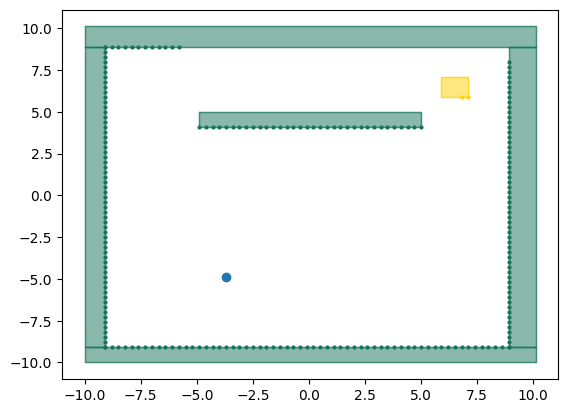

In [3]:
from bbtoolkit.utils.viz import plot_polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
position = 1000 # the position of the agent (visible area has dimensionality n_positions x 2)
env = compiler.environment
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

In [4]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = len(compiler.environment.objects)

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [5]:
# mtl_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/mtl_weights (5).pkl')
# tc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/tc_weights (2).pkl')
# hd_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/hd_weights (2).pkl')
# pc_weights = DirectedTensorGroup.load('../../../Downloads/Telegram Desktop/pc_weights (2).pkl')
# gc_map = GCMap.load('../../../Downloads/Telegram Desktop/gc_map (2).pkl')

mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_inserted_wall.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_inserted_wall.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_inserted_wall.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_inserted_wall.pkl')
gc_map = GCMap.load('../data/weights/gc_map_inserted_wall.pkl')

# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_square.pkl')
# tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_square.pkl')
# hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
# pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_square.pkl')
# gc_map = GCMap.load('../data/weights/gc_map_square.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [6]:
activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [7]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

In [8]:
red = '#b20000'
green = '#00b2b2'
cmap = generate_cmap(*[
    green,
    '#fff',
    red
])

In [9]:
weights.bvc.to.h

array([[4.75663849e-03, 5.17587249e-03, 4.13567169e-03, ...,
        3.27897071e-03, 3.13103698e-03, 3.37245944e-03],
       [4.62622796e-03, 4.64815686e-03, 3.43086524e-03, ...,
        3.33400180e-03, 3.18264243e-03, 3.44961551e-03],
       [4.50817040e-03, 4.17088022e-03, 2.75959278e-03, ...,
        3.41040285e-03, 3.26278483e-03, 3.57680916e-03],
       ...,
       [4.33499478e-03, 3.83570926e-03, 2.25535908e-03, ...,
        5.16195459e-20, 3.03539046e-20, 1.93613223e-20],
       [4.43787611e-03, 3.91692454e-03, 2.30647160e-03, ...,
        5.25689443e-20, 3.09148414e-20, 1.99471583e-20],
       [4.55432073e-03, 4.00583305e-03, 2.36390828e-03, ...,
        5.35655433e-20, 3.15010355e-20, 2.04483334e-20]])

In [10]:
weights.h.to.bvc.T

array([[6.81724376e-04, 6.71056753e-04, 5.38366750e-04, ...,
        3.88711762e-04, 4.03408058e-04, 4.88436073e-04],
       [9.20147457e-04, 8.36330975e-04, 6.19808543e-04, ...,
        5.48501346e-04, 5.69070330e-04, 6.93351422e-04],
       [9.96102130e-04, 8.33677861e-04, 5.53824344e-04, ...,
        6.23290768e-04, 6.48096497e-04, 7.98641055e-04],
       ...,
       [1.02951404e-03, 8.24055344e-04, 4.86500048e-04, ...,
        1.01400323e-20, 6.48046177e-21, 4.64655439e-21],
       [9.52327460e-04, 7.60367146e-04, 4.49554907e-04, ...,
        9.33086391e-21, 5.96383816e-21, 4.32558136e-21],
       [7.06947888e-04, 5.62501442e-04, 3.33286642e-04, ...,
        6.87750270e-21, 4.39578368e-21, 3.20755436e-21]])

In [11]:
from typing import Mapping

from bbtoolkit.dynamics.callbacks import BaseCallback

class PCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0, i_comp_scale: float = 1):
        super().__init__()
        self.i_comp = i_comp
        self.i_comp_scale = i_comp_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'grid2cart'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.h.to.h['phi']*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.rates.i_comp
        )
        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.cache['k_ratio'].h += self.connectivity.bvc.to.h['phi']*10*self.weights.bvc.to.h@self.rates.bvc
            case 'recall':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr
            case 'top-down':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr +\
                    self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc

        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        # self.rates.h = self.weights.bvc.to.h@self.rates.bvc
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(self.i_comp_scale - np.sum(self.rates.h))


In [12]:
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


class DebugArtist(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'gc',
            'rates',
            'activity',
            'debug_ax1',
            'weights',
            'grid2cart',
            'movement_params',
            'encoding_params',
        ]
        cache['debug_ax1'] = cache['fig'].add_subplot(cache['gc'][8:12, 4:8])
        cache['fig'].tight_layout()
        super().set_cache(cache, on_repeat=on_repeat)

    def on_plot(self):
        # self.debug_ax1.imshow(self.weights.ovc.to.opr, aspect='auto', origin='lower')
        # self.debug_ax1.imshow(
        #     np.reshape(
        #         (self.weights.gc.to.h@self.rates.gc),
        #         self.grid2cart.shape
        #     ),
        #     cmap='coolwarm',
        # )
        self.debug_ax1.plot(self.activity.hd)

    def on_clean(self):
        self.debug_ax1.clear()

In [13]:
import math


class HDCallback(BaseCallback):
    """
    A callback designed for handling head direction (HD) cues and updating HD cell activities in an agent-based learning simulation.

    This callback integrates external HD cues, manages HD cell activities based on movement and cognitive states, and updates the agent's perceived direction.

    Attributes:
        init_timesteps (int): The number of initial timesteps during which HD cues are applied.
        hd_cue_scale (float): The scale factor for HD cues.
        no_cue_reset_modes (tuple[str, ...]): Modes in which HD cues are not reset.
        total_steps (int): Counter for the steps during which HD cues are active.
        mode (str): The current mode of the simulation.
    """
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
        no_cue_reset_modes: tuple[str, ...] = ('recall', 'top-down')
    ):
        """
        Initializes the HDCallback instance with specified parameters for HD cue initialization and scaling.

        Args:
            init_timesteps (int): The number of initial timesteps during which HD cues are applied.
            hd_cue_scale (float): The scale factor for HD cues.
            no_cue_reset_modes (tuple[str, ...]): Modes in which HD cues are not reset.
        """
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None
        self.no_cue_reset_modes = no_cue_reset_modes

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        """
        Sets the cache with the provided mapping, specifies the required cache keys for HD cue management, and initializes HD cues.

        Args:
            cache (Mapping): The new cache mapping.
            on_repeat (str): The behavior when a cache key is already an attribute. Defaults to 'raise'.
        Notes:
            The `self.requires` attribute specifies the following required parameters:
            - `dynamics_params`: Contains dynamic parameters of the simulation, including the current mode (e.g., 'bottom-up', 'top-down', 'recall').
            - `tc_gen`: Transformation circuit generator for HD activity.
            - `movement_params`: Contains the physical movement parameters of the agent, including its current position.
            - `mental_movement_params`: Contains the mental movement parameters of the agent during cognitive navigation tasks.
            - `hd_cue`: HD cue array for external directional cues.
            - `k_ratio`: Ratio of excitation/inhibition for HD cells.
            - `activity`: Neural activity levels.
            - `connectivity`: Connectivity matrices between neural populations.
            - `weights`: Synaptic weights between neurons.
            - `rates`: Firing rates of neurons.
        """
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'tc_gen',  # Transformation circuit generator for HD activity.
            'movement_params',  # Movement parameters including position and direction.
            'mental_movement_params',  # Mental movement parameters for cognitive navigation.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates'  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        """
        Updates HD cues and cell activities at the beginning of each simulation step, based on the agent's movement and cognitive state.

        Args:
            step (int): The current step number.
        """
        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        match self.dynamics_params['mode']:
            case 'bottom-up':
                params = self.movement_params
                target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
                position = self.movement_params.position
                direction = self.movement_params.direction
            case 'top-down':
                params = self.mental_movement_params
                target = self.mental_movement_params.move_target if self.mental_movement_params.move_target is not None else self.mental_movement_params.rotate_target
                position = self.mental_movement_params.position
                direction = self.mental_movement_params.direction
            case 'recall':
                params, target, position, direction = None, None, None, None

        if target is not None:
            angle_to_target = math.atan2(
                target[1] - position[1],
                target[0] - position[0]
            ) % (2*np.pi)

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = (
            -self.activity.hd
            # + (self.connectivity.hd.to.hd['phi']*
            +(self.weights.hd.to.hd@self.rates.hd)
            # + self.hd_cue[:, np.newaxis]
            # + (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)
        )

        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            params.direction = hd_estim

In [14]:
rates.hd

array([[0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.26894142],
       [0.268

In [15]:
raise

RuntimeError: No active exception to reraise

In [ ]:
weights.hd.to.hd@rates.hd

array([[-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9.32756439],
       [-9

In [ ]:
%matplotlib qt

logging.getLogger('matplotlib').setLevel(logging.WARNING)

dt = .005

position = (7, -7)
direction = np.pi/2
attn_dist = 7.5

connectivity2use = connectivity.copy()
connectivity2use.h.to.h['phi'] = 4
# connectivity2use.pr.to.h['phi'] = 0
# connectivity2use.ovc.to.h['phi'] = 0
# connectivity2use.bvc.to.h['phi'] = 1000


weights2use = weights.copy()
# weights2use.bvc.to.h = bvc2h

cache = BBCache(
    connectivity2use,
    weights2use,
    k_ratio.copy(),
    activity.copy(),
    rates.copy(),
    tc_gen,
    compiler.environment,
    Grid2CartTransition(compiler.environment),
    DynamicParameters(dt, 'bottom-up'),
    EcodingParameters(),
    ClickParameters()
)

cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        MentalPositionCallback(),
        MentalMovementCallback(
            MovementManager(
                5,
                np.pi*2,
                position,
                direction
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        MentalMovementSchedulerCallback(),
        MentalTrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        AttentionCallback(
            DistanceAttention(7, dt, len(compiler.environment.objects), attn_dist)
        ),
        HDCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        PlottingCallback(
            [
                AloEnvPlotter(
                    attn_color=red
                ),
                EgoEnvPlotter(
                    attn_color=red
                ),
                MouseEventCallback(),
                TimerPlotter(),
                AgentPlotter(),
                TargetPlotter(
                    move_target_color=red
                ),
                TrajectoryPlotter(
                    target_color=red
                ),
                PWPlotter(cmap=cmap),
                BVCPlotter(cmap=cmap),
                oPWPlotter(cmap=cmap),
                OVCPlotter(cmap=cmap),
                # HDPlotter(cmap=cmap),
                PCPlotter(cmap=cmap),
                # oPRPlotter(
                #     '#00b2b2',
                #     '#b20000'
                # ),
                DebugArtist(),
                ObjectRecallCallback(),
                PickedObjectPlotter(),
                DistanceAttentionPlotter(attn_dist, color=red),
                MentalAgentPlotter(),
                MentalTargetPlotter(),
                MentalTrajectoryPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

KeyboardInterrupt: 

In [ ]:
for _ in dynamics(True):
    print('out: ', _)

KeyboardInterrupt: 

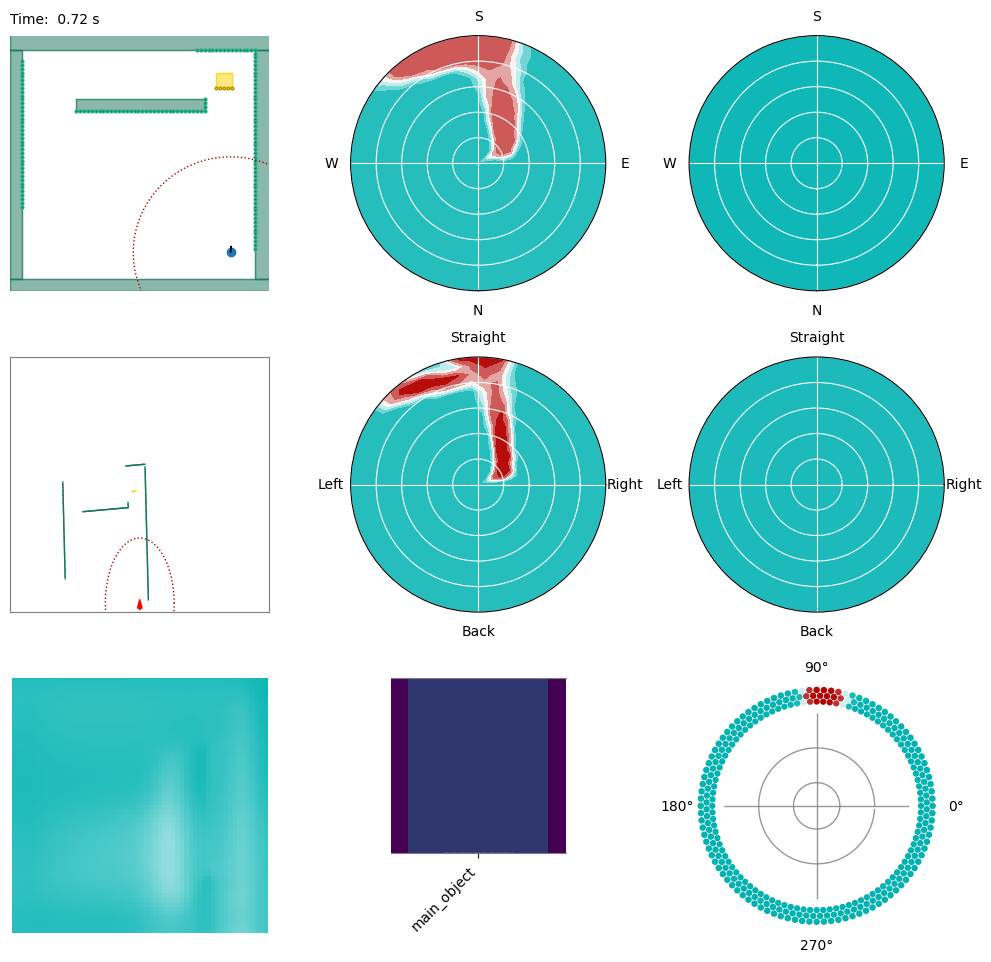

In [ ]:
%matplotlib inline
plt.show()

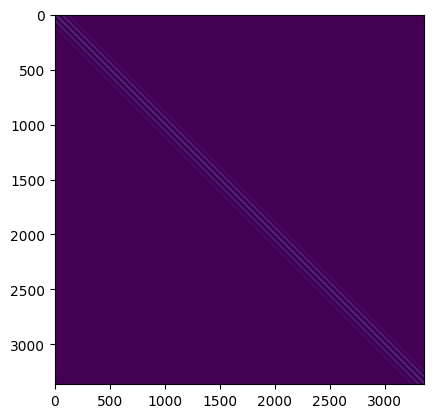

In [ ]:
%matplotlib inline
plt.imshow(cache.weights.h.to.h)

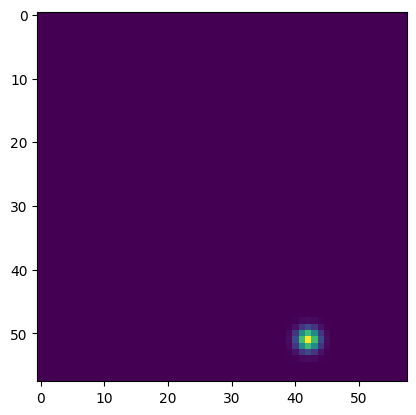

In [ ]:
%matplotlib inline
plt.imshow(np.reshape(cache.weights.h.to.h[3000], cache.grid2cart.shape))

In [ ]:
weights.bvc.to.h.shape

(3364, 816)

In [ ]:
bvc2h = weights.bvc.to.h.copy()

bvc2h = np.reshape(bvc2h, (*cache.grid2cart.shape, n_bvc_neurons))
bvc2h = np.transpose(bvc2h, (1, 0, 2))
bvc2h = np.reshape(bvc2h, (cache.grid2cart.shape[1]*cache.grid2cart.shape[0], n_bvc_neurons))

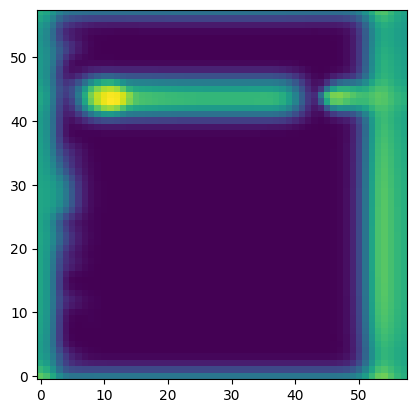

In [ ]:
plt.imshow(np.reshape(bvc2h[:, 1], cache.grid2cart.shape), origin='lower')

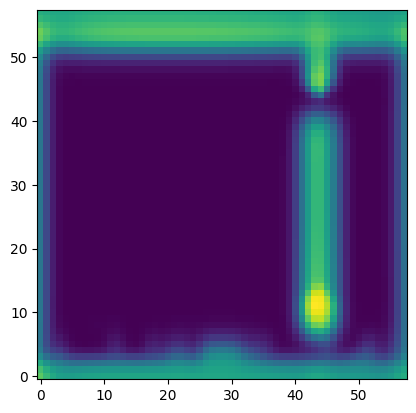

In [ ]:
plt.imshow(np.reshape(weights.bvc.to.h[:, 1], cache.grid2cart.shape), origin='lower')

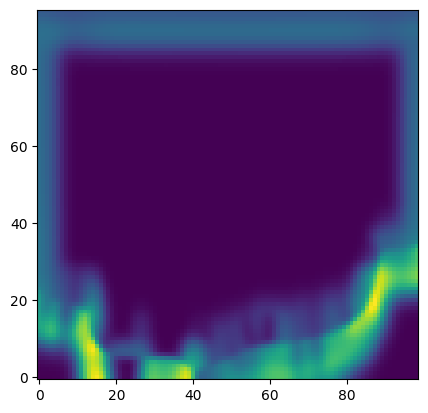

In [ ]:
plt.imshow(np.reshape(weights.bvc.to.h[:, 1], cache.grid2cart.shape), origin='lower')

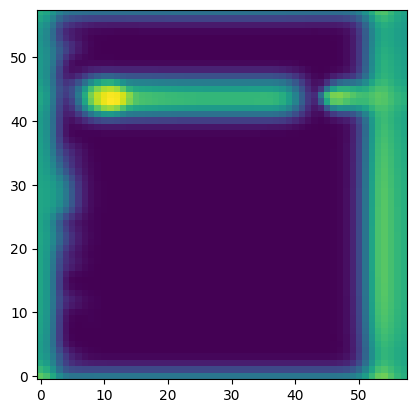

In [ ]:
%matplotlib inline
plt.imshow(np.reshape(cache.weights.bvc.to.h[:, 1], cache.grid2cart.shape), origin='lower')

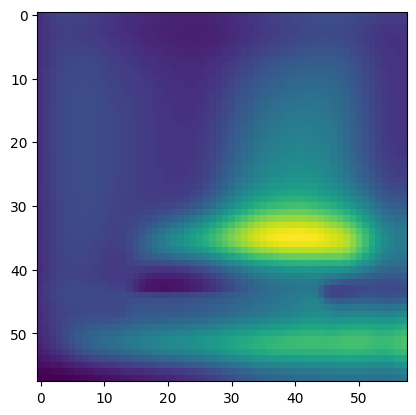

In [ ]:
plt.imshow(np.reshape(cache.weights.bvc.to.h@cache.rates.bvc, cache.grid2cart.shape))

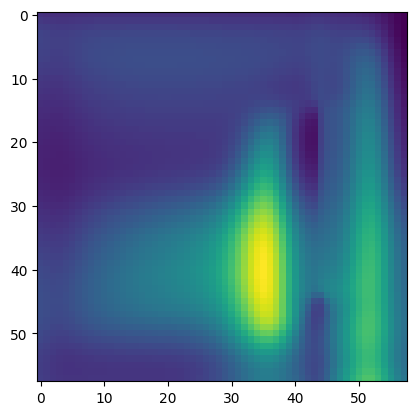

In [ ]:
plt.imshow(np.reshape(weights.bvc.to.h@cache.rates.bvc, cache.grid2cart.shape))

In [ ]:
cache.rates.h

array([1.14745178e-05, 1.36556780e-05, 1.64338793e-05, ...,
       4.57565300e-03, 4.62450902e-03, 4.66128520e-03])

In [ ]:
from bbtoolkit.utils.viz.video import make_video_from_images


image_directory = '../tmp'
video_save_path = './square_transposed_bvc2h.mp4'
make_video_from_images(image_directory, video_save_path, 4)

In [ ]:
from bbtoolkit.utils.datautils import remove_files_from_dir

image_directory = '../tmp'
remove_files_from_dir(image_directory)

In [ ]:
raise

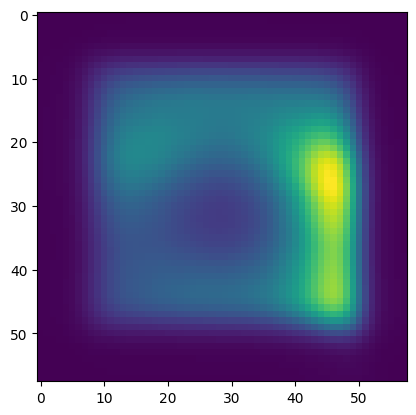

In [ ]:
%matplotlib inline
plt.imshow(np.reshape(cache.rates.h, cache.grid2cart.shape))

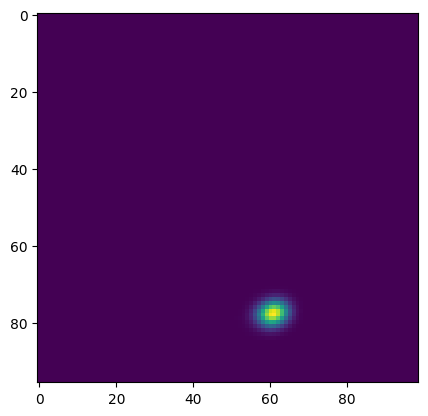

In [ ]:
plt.imshow(np.reshape(cache.weights.h.to.h@cache.rates.h, cache.grid2cart.shape))

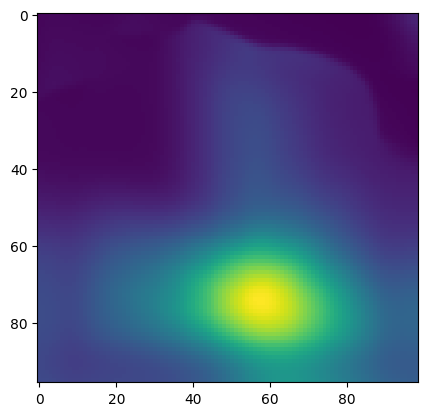

In [ ]:
plt.imshow(np.reshape(cache.weights.bvc.to.h@cache.rates.bvc, cache.grid2cart.shape))